In [57]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt
import pickle as pkl
from scipy import sparse

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [59]:
import re
import itertools
import string
import collections   #for treating missing values/ couting objects
from collections import Counter
from sklearn.preprocessing import LabelEncoder  #encoding categorical data to numerical

In [60]:
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords     #remove symantically right eng words from text -> don't add value to prediction
from nltk import word_tokenize        #regulate words by considering common suffix/prefix that essentially mean the same
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [61]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer #significance of a word to record in a corpus
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.cluster as cluster
from sklearn.manifold import TSNE 
from sklearn.model_selection import train_test_split


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [63]:
data_set = pd.read_csv("mbti_1.csv")

Kaggle's MBTI personality dataset encompasses 8675 users with 422845 posts/comments about each personality type

In [64]:
#data profiling

In [65]:
data_set.info() #describing data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [66]:
data_set.shape #number of rows and columns

(8675, 2)

In [67]:
data_set[data_set.isnull()].count() #number of null values

type     0
posts    0
dtype: int64

In [68]:
print(data_set['type'].nunique())#number of unique MBTI data types in this dataset
print(np.unique(np.array(data_set['type'])))

16
['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [69]:
data_set.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [70]:
data_set.head(20)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [71]:
#total number of users and posts
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))
posts = []
data_set.apply(lambda x: extract(x, posts), axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
8670    None
8671    None
8672    None
8673    None
8674    None
Length: 8675, dtype: object

In [72]:
len(data_set) #number of users

8675

In [73]:
len(posts) #number of posts

422845

Visualising

In [74]:
p_post = data_set['type'].value_counts()

Text(0.5, 1.0, 'Posts with regards to each personality type')

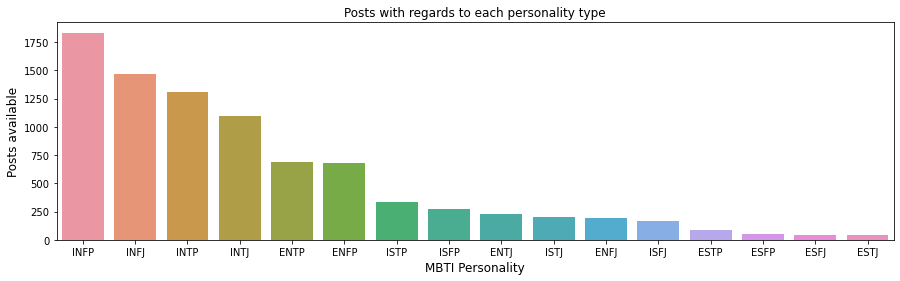

In [75]:
plt.figure(figsize = (15,4))
sns.barplot(x=p_post.index, y=p_post.values)
plt.xlabel('MBTI Personality', size = 12)
plt.ylabel('Posts available', size = 12)
plt.title('Posts with regards to each personality type')

Wordcloud to see most common words used, after removing stopwords

In [76]:
words = list(data_set["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]

In [77]:
stopwords = set(STOPWORDS)

In [78]:
wc = wordcloud.WordCloud(stopwords =stopwords, width=1200, height=500, 
                         collocations=False, background_color="black", 
                         colormap="tab20b").generate(" ".join(words))

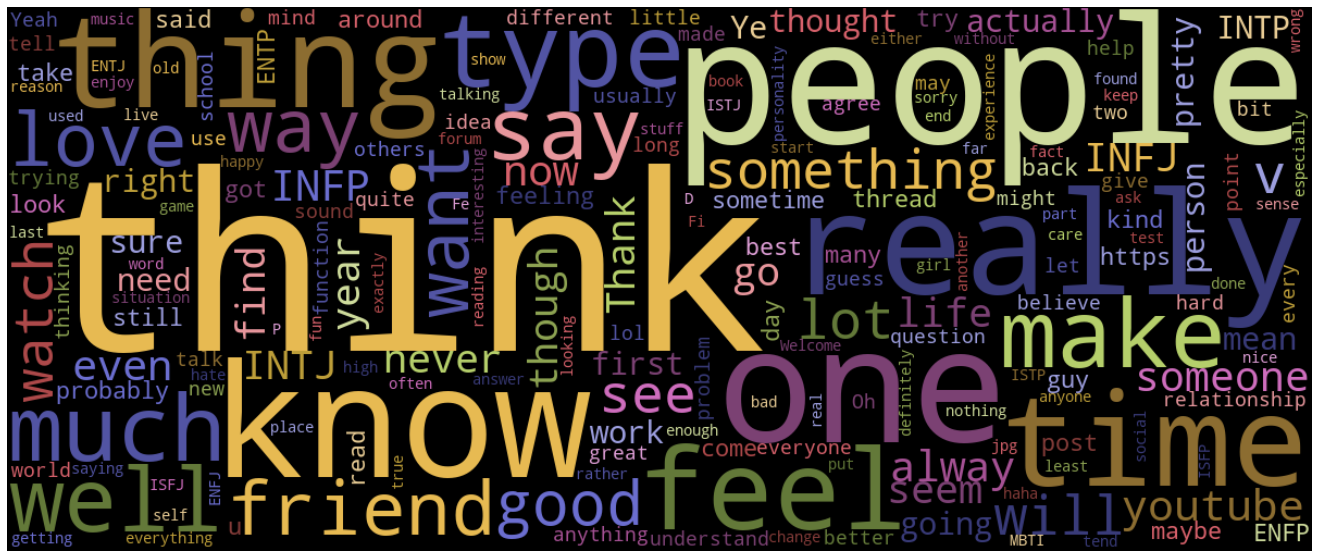

In [79]:
plt.figure(figsize=(25,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

First, let's find out, what each syllable in the above personality type stands for :

I/E : Introversion/Extroversion N/S : Sensors/Intuitives T/F : Thinkers/Feelers J/P : Judgers/Perceivers

In [80]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data_set = data_set.join(data_set.apply (lambda row: get_types (row),axis=1))
data_set.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [81]:
print ("Introversion (I) /  Extroversion (E):\t", data_set['IE'].value_counts()[0], " / ", data_set['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data_set['NS'].value_counts()[0], " / ", data_set['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data_set['TF'].value_counts()[0], " / ", data_set['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data_set['JP'].value_counts()[0], " / ", data_set['JP'].value_counts()[1])
print()
print()

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) / Sensing (S):		 1197  /  7478
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 5241  /  3434




In [82]:
#Plotting the distribution
N = 4 #4 broad classifications

In [83]:
#count when the chars are 0 - indicating extroversion 
bottom = (data_set['IE'].value_counts()[0], data_set['NS'].value_counts()[0], data_set['TF'].value_counts()[0], data_set['JP'].value_counts()[0])
#count when the chars are 1 - indicating intoversion
top = (data_set['IE'].value_counts()[1], data_set['NS'].value_counts()[1], data_set['TF'].value_counts()[1], data_set['JP'].value_counts()[1])


In [84]:
ind = np.arange(N)    # the x locations for the groups(index)
# the width of the bars
width = 0.3 

In [85]:
print(bottom)
print(top)

(1999, 1197, 4694, 5241)
(6676, 7478, 3981, 3434)


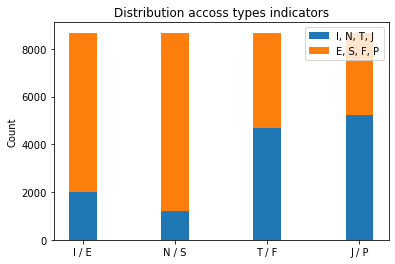

In [86]:
p1 = plt.bar(ind, bottom, width, label="I, N, T, J")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

Orange is more.

Extroverets are more as per our dataset.

So the comments /posts in our dataset would be more about rare ones

i.e, about introverts
even if dataset population is more of extroverts


In [87]:
data_set = data_set[['type','posts']]
data_set.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


Data Preprocessing

In [88]:
def process_txt(df, remove_special=True):
    
    #Change case => lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())
    
    #Remove acronyms of personality types within text, for accrate prediction with unknown data
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
        
        #Substitute hyperlinks with space 
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))

        #Substitute all punctuation except EOS characters
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))  #remove punctuation
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))  #avoid multiple full stops

        #Remove Numeric + Spl chars
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

        #Remove multiple letters
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 
        #Keep words within acceptable range (min letter 3, max 30)
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
        df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))
        return df

In [89]:
#Call function on data set
df = process_txt(data_set, remove_special=True)
df.head()
df.shape

(8675, 2)

In [90]:
#Set benchmark for comments/posts - minimum length
min_w = 10
print ("All posts :", df.shape[0])
df['Words'] = df['posts'].apply(lambda x: len(re.findall(r'\w+',x)))
df = df[df['Words'] >= min_w] 
print ("Benchmarked posts :", df.shape[0])
print()

df.head()

All posts : 8675
Benchmarked posts : 8504



,type,posts,Words
0,INFJ,enfp intj moments sportscenter plays...,430
1,ENTP,finding lack these posts very alarming EO...,803
2,INTP,good course which know thats bles...,253
3,INTJ,dear intp enjoyed conversation other EOS...,777
4,ENTJ,youre fired EOSTokenDot thats another silly...,402


Benchmarked posts about personalities

Splitting X and Y feature

In [91]:
enc = LabelEncoder()
df['type of encoding'] = enc.fit_transform(df['type'])

target = df['type of encoding'] 

C:\Users\Windows 10\AppData\Local\Temp\ipykernel_23136\1182116927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type of encoding'] = enc.fit_transform(df['type'])


In [92]:
df.head(15)

,type,posts,Words,type of encoding
0,INFJ,enfp intj moments sportscenter plays...,430,8
1,ENTP,finding lack these posts very alarming EO...,803,3
2,INTP,good course which know thats bles...,253,11
3,INTJ,dear intp enjoyed conversation other EOS...,777,10
4,ENTJ,youre fired EOSTokenDot thats another silly...,402,2
5,INTJ,EOSTokenDot science perfect EOSTokenDo...,245,10
6,INFJ,cant draw nails haha EOSTokenDot those w...,970,8
7,INTJ,tend build collection things desktop th...,140,10
8,INFJ,sure thats good question EOSTokenDot dist...,522,8
9,INTP,this position where have actually pe...,130,11


In [93]:
# Vectorizing the posts for the model and filtering Stop-words
vect = CountVectorizer(stop_words='english') 

# Converting posts (or training or X feature) into numerical form by count vectorization
train =  vect.fit_transform(df["posts"])

In [94]:
train.shape

(8504, 98563)

So now there are 98555 features in our dataset for 8466 rows

When we give a description abouut a personlity, it should predict the one of MBTI personality from the text. For that lets train model from our dataset.

Training & Evaluating : 60-40 split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5102, 98563) (5102,) (3402, 98563) (3402,)


In [99]:
from sklearn.metrics import accuracy_score

In [101]:
#XG boost Classifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

Y_pred = xgb.predict(X_test)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 56.50%


The accuracy is around 50%. Its very low.

i.e. the model has not learned enough from the training data, resulting in low generalization and unreliable predictions.